In [1]:
import pandas as pd

# Leer el archivo CSV correctamente (incluyendo el espacio en el nombre)
df = pd.read_csv('../data/raw/df_cup_primary.csv', sep=",", encoding="latin-1", low_memory=False)

# Mostrar resultados
print(df.shape)
print(df.head())
print(df.info())




(3895, 129)
   COD_HOSPITAL  ID_BENEFICIARIO    SEXO FECHA_NACIMIENTO    ETNIA  \
0        114101         67717452   MUJER       1952-11-11  NINGUNO   
1        114101         67782077   MUJER       1948-02-02  NINGUNO   
2        116100         70825100  HOMBRE       1953-11-07  NINGUNO   
3        123100         77185788  HOMBRE       1964-11-05  NINGUNO   
4        105100         74846673   MUJER       1953-08-24  NINGUNO   

    PROVINCIA       COMUNA NACIONALIDAD                       PREVISION  \
0  CORDILLERA  PUENTE ALTO        CHILE  FONASA INSTITUCIONAL - (MAI) B   
1    SANTIAGO   LA FLORIDA        CHILE  FONASA INSTITUCIONAL - (MAI) B   
2      CURICO       MOLINA        CHILE  FONASA INSTITUCIONAL - (MAI) B   
3      OSORNO       OSORNO        CHILE  FONASA INSTITUCIONAL - (MAI) A   
4      LIMARI       OVALLE        CHILE  FONASA INSTITUCIONAL - (MAI) B   

             SERVICIO_SALUD  ... FECHAPROCEDIMIENTO1 FECHAINTERV1  \
0  METROPOLITANO SURORIENTE  ...               

FASE 1 Auditoría temporal (RA1) :
# 1) Detectar y parsear columnas de fecha
# 2) Elegir la mejor columna de evento temporal (evita FECHA_NACIMIENTO)
# 3) Ordenar, proponer frecuencia y auditar outliers
# 4) Dejar una mini-bitácora impresa de la auditoría

DF 2024 0       2024-09-20
1       2024-11-12
2       2024-06-24
3       2024-04-03
4       2024-03-01
           ...    
3890    2024-08-26
3891    2024-08-13
3892    2024-01-01
3893    2024-10-12
3894    2024-08-27
Name: FECHA_INGRESO, Length: 3809, dtype: object
== Columnas con pinta de fecha (ordenadas por conveniencia) ==
                col  score  coverage  n_non_null
      FECHA_INGRESO      2  1.000000        3809
          FECHAALTA      2  1.000000        3809
       FECHAINTERV1      2  0.485954        1851
FECHAPROCEDIMIENTO1      2  0.000000           0
     FECHATRASLADO1      0  0.269625        1027
     FECHATRASLADO2      0  0.129168         492
     FECHATRASLADO3      0  0.037280         142
     FECHATRASLADO4      0  0.012602          48
     FECHATRASLADO5      0  0.004726          18
     FECHATRASLADO6      0  0.002100           8
     FECHATRASLADO7      0  0.000525           2
     FECHATRASLADO8      0  0.000000           0
     FECHATRASLADO9      0  0.0000

C:\Users\musra\AppData\Local\Temp\ipykernel_16172\2146493573.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df_2024[c], errors='coerce', infer_datetime_format=True)
C:\Users\musra\AppData\Local\Temp\ipykernel_16172\2146493573.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df_2024[c], errors='coerce', infer_datetime_format=True)
C:\Users\musra\AppData\Local\Temp\ipykernel_16172\2146493573.py:33: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict 

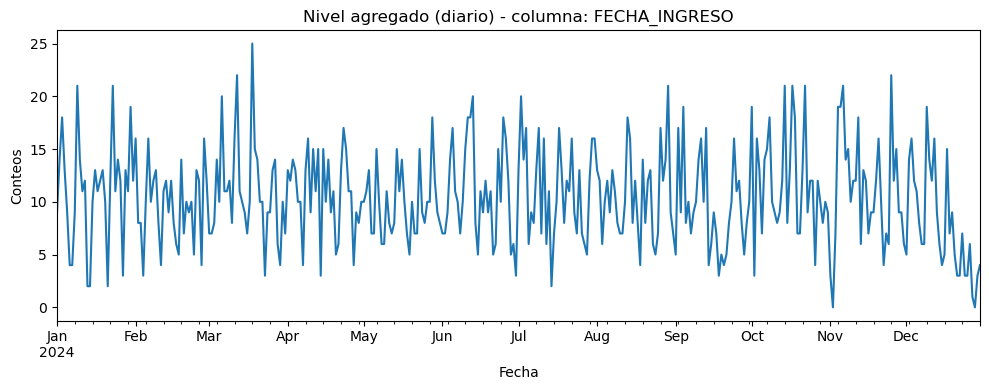


Artefacto auditoría: {'best_col': 'FECHA_INGRESO', 'range': ('2024-01-01', '2024-12-30'), 'span_days': 365, 'density': 0.9945205479452055, 'freq_propuesta': 'D', 'missing_ratio_resample': 0.0, 'n_outliers_IQR': 1}

'ts' listo para EDA (Fase 2). Primeras filas:
2024-01-01     9
2024-01-02    14
2024-01-03    18
2024-01-04    13
2024-01-05     9
2024-01-06     4
2024-01-07     4
2024-01-08     9
2024-01-09    21
2024-01-10    14
2024-01-11    11
2024-01-12    12
Freq: D, Name: y, dtype: int64


In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_2024 = df[df['FECHA_INGRESO'].str.contains('2024', na=False)]

print(f"DF 2024 {df_2024['FECHA_INGRESO']}")

assert 'df' in globals(), "No encuentro el DataFrame 'df'. Carga tu CSV antes."

# 1) Candidatas a fecha (por nombre)
date_like = [c for c in df_2024.columns if re.search(r'fecha|date', c, flags=re.I)]
if not date_like:
    raise ValueError("No encontré columnas con nombre tipo 'FECHA'/'DATE'.")

# Palabras clave para fechas de evento (ingreso/alta/egreso/procedimiento/intervención/ocurrencia)
prefer = ['ingres', 'alta', 'egres', 'ocurr', 'proc', 'interv']
avoid  = ['nac']   # evitar fechas de nacimiento como serie objetivo

def score_col(col):
    name = col.lower()
    s = 0
    if any(p in name for p in prefer):
        s += 2
    if any(a in name for a in avoid):
        s -= 5
    return s

# 2) Intentar parsear todas y medir cobertura
parsed_info = []
for c in date_like:
    s = pd.to_datetime(df_2024[c], errors='coerce', infer_datetime_format=True)
    coverage = s.notna().mean()
    parsed_info.append({
        'col': c,
        'score': score_col(c),
        'coverage': coverage,
        'n_non_null': int(s.notna().sum())
    })

cand = pd.DataFrame(parsed_info).sort_values(['score','coverage','n_non_null'], ascending=[False, False, False])
best_col = cand.iloc[0]['col']
best_cov = cand.iloc[0]['coverage']

if best_cov < 0.01:
    raise ValueError(f"No hay columna de fecha con cobertura suficiente. Vistas: \n{cand}")

print("== Columnas con pinta de fecha (ordenadas por conveniencia) ==")
print(cand.to_string(index=False))
print("\nElegida como serie temporal objetivo:", best_col)

# df_2024 = df[df['FECHA_INGRESO'].dt.year == 2024]

# 3) Construir serie base (nivel diario por defecto) y auditar
dates = pd.to_datetime(df_2024[best_col], errors='coerce')
base = (pd.DataFrame({'date': dates})
        .dropna()
        .sort_values('date'))

# Si la columna tiene hora/minuto, la llevamos a fecha (día)
if (base['date'].dt.time != pd.to_datetime('00:00:00').time()).any():
    base['date'] = base['date'].dt.floor('D')

# Span temporal
dmin, dmax = base['date'].min(), base['date'].max()
span_days = (dmax - dmin).days + 1

# Conteo por día
yD = base.groupby('date').size().rename('y').to_frame()

# Densidad temporal: proporción de días con dato respecto al span continuo
density = len(yD) / span_days

# Propuesta de frecuencia (heurística simple por resolución y densidad)
# Si la densidad diaria es baja, proponemos semanal o mensual.
if density >= 0.6 and span_days >= 90:
    freq = 'D'
elif span_days >= 180:
    freq = 'W'  # semanal
else:
    freq = 'M'  # mensual

# Reindexar a la frecuencia propuesta para auditar huecos
full_idx = pd.date_range(dmin, dmax, freq='D') if freq=='D' else pd.date_range(dmin, dmax, freq=freq)
y_full = yD['y'].resample(freq).sum().reindex(full_idx)
missing_ratio = y_full.isna().mean()

# Outliers en nivel agregado (IQR)
y_vals = y_full.dropna()
Q1, Q3 = y_vals.quantile(0.25), y_vals.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = max(Q1 - 1.5*IQR, 0)  # para conteos, no tiene sentido < 0
outliers_idx = y_vals[(y_vals>upper) | (y_vals<lower)].sort_values(ascending=False)

# 4) Mini-bitácora de auditoría
print("\n== Auditoría temporal ==")
print(f"Rango temporal: {dmin.date()} → {dmax.date()}  (span: {span_days} días)")
print(f"Densidad de días con registro: {density:.2%}")
print(f"Frecuencia propuesta: { {'D':'diaria','W':'semanal','M':'mensual'}[freq] }")
print(f"Huecos en la serie reindexada a {freq}: {missing_ratio:.2%} de los períodos")
print(f"Outliers detectados (IQR): {len(outliers_idx)}")

print("\nFechas con mayor conteo (top 10):")
print(y_vals.sort_values(ascending=False).head(10))

if len(outliers_idx):
    print("\nTop outliers por conteo:")
    print(outliers_idx.head(10))

# Gráfico rápido del nivel agregado (según freq propuesta)
plt.figure(figsize=(10,4))
y_full.plot()
plt.title(f"Nivel agregado ({ {'D':'diario','W':'semanal','M':'mensual'}[freq] }) - columna: {best_col}")
plt.xlabel("Fecha")
plt.ylabel("Conteos")
plt.tight_layout()
plt.show()

# Guardar artefactos intermedios útiles para las siguientes fases
auditoria = {
    'best_col': best_col,
    'range': (str(dmin.date()), str(dmax.date())),
    'span_days': int(span_days),
    'density': float(density),
    'freq_propuesta': freq,
    'missing_ratio_resample': float(missing_ratio),
    'n_outliers_IQR': int(len(outliers_idx)),
}
print("\nArtefacto auditoría:", auditoria)

# Dejar la serie agregada como 'ts' para continuar en Fase 2
ts = y_full.rename('y')  # índice = fecha (según freq propuesta), valores = conteo
print("\n'ts' listo para EDA (Fase 2). Primeras filas:")
print(ts.head(12))

CONCLUSION: FASE 1:
#Columna de fecha: detectada correctamente: OK
#Rango temporal: cubres de enero a diciembre de 2024.
#Frecuencia: diaria.
#Calidad: 99.5% de densidad, 0% NULK, 1 outlier la serie está practicamente limpia.
#Nivel: los días con más registros tienen entre ~20 y 25 casos.

COLUMNA TEMPORAL QUE SE ELIGE: FECHAALTA.

RA2. EDA

Dibuja los 4 gráficos  (nivel, cambios, STL, boxplots por día y por mes)

Calcular automáticamente 2–3 ideas clave por figura y las imprime listas para copiar al informe

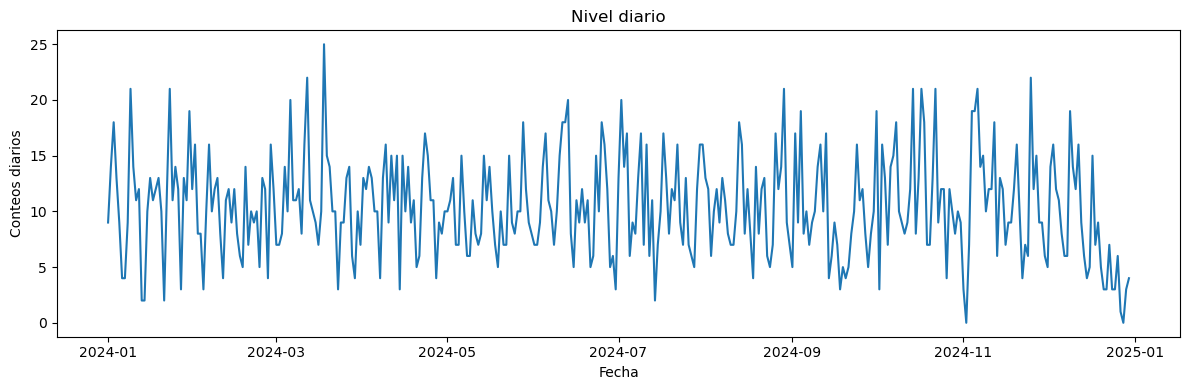


[Ideas clave — Nivel diario]
• Rango temporal analizado: 2024-01-01 → 2024-12-30 (365 días).
• Mínimo diario: 0 el 2024-11-02; máximo diario: 25 el 2024-03-18.


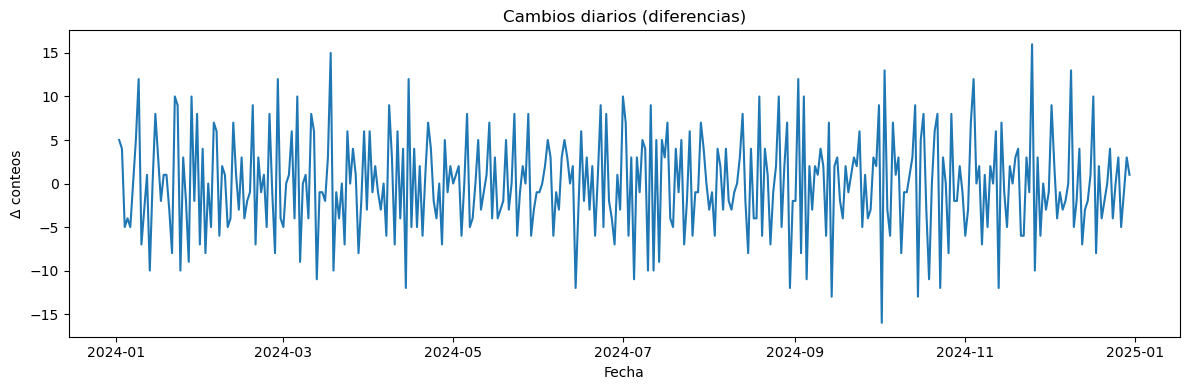


[Ideas clave — Cambios diarios]
• Variación típica: |Δ| medio ≈ 4.4 casos/día.
• Sesgo de movimientos: 45.1% de días con alzas vs 54.9% con bajas.
• Mayor alza en un día: +16 el 2024-11-25; mayor baja: -16 el 2024-10-02.


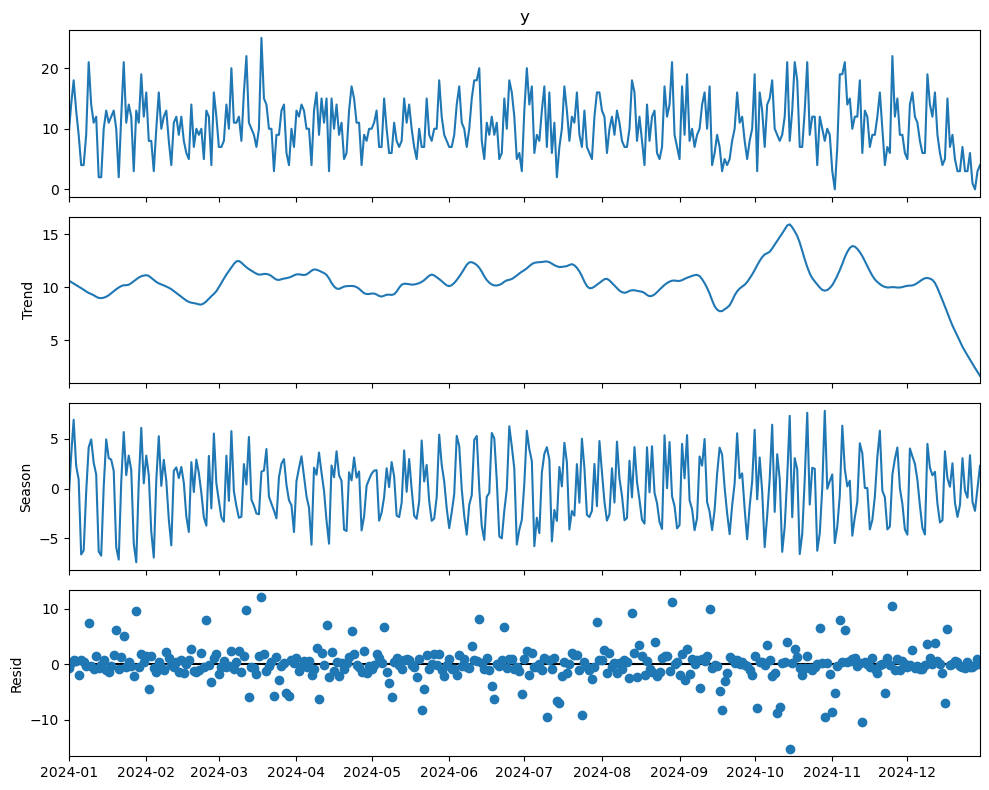


[Ideas clave — STL (tendencia/estacionalidad/residuo)]
• Amplitud estacional semanal ≈ 15.2 (146.0% del nivel medio).
• Día con sesgo estacional más alto: Tuesday (≈ 2.9 sobre la media, en el componente estacional).
• Ruido (residuo) explica ≈ 47.4% de la varianza del componente sin nivel.


<Figure size 1000x500 with 0 Axes>

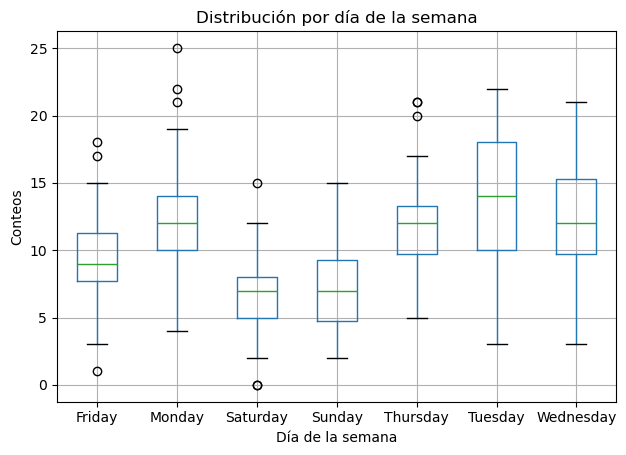

<Figure size 1000x500 with 0 Axes>

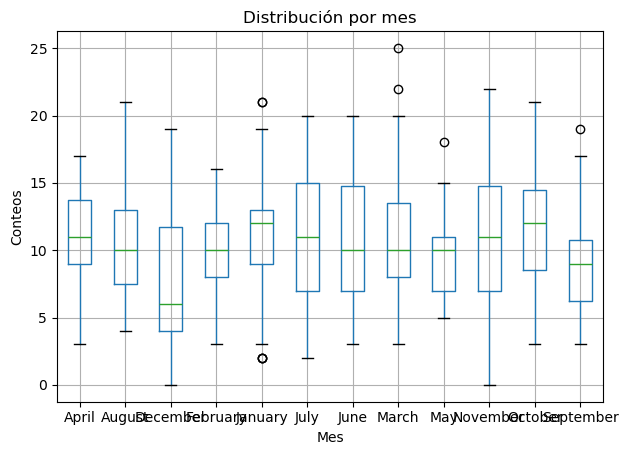


[Ideas clave — Estacionalidad (boxplots)]
• Días más altos (promedio): Tuesday (13.7), Monday (12.3). Día más bajo: Saturday (6.6).
• Relación tope/fondo por día: ×2.07.
• Meses más altos (promedio): October (11.9), November (11.1). Mes más bajo: December (7.7).
• Relación tope/fondo por mes: ×1.54.

Figuras guardadas en: reports/figures/


In [3]:
# === RA2 — EDA con descomposición: gráficos + ideas clave automáticas ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

df_2024_altas = df[df['FECHAALTA'].str.contains('2024', na=False)]

assert 'ts' in globals(), "No encuentro la serie 'ts'. Ejecuta la Fase 1 antes (ts = serie diaria por FECHAALTA)."
os.makedirs("../reports/figures", exist_ok=True)

# Asegurar índice datetime ordenado
ts = ts.copy().dropna()
ts = ts[~ts.index.duplicated()].sort_index()

# ---------------------------
# 1) Gráfico de nivel (serie original)
# ---------------------------
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values)
plt.title("Nivel diario")
plt.xlabel("Fecha"); plt.ylabel("Conteos diarios")
plt.tight_layout()
plt.savefig("../reports/figures/ra2_nivel_diario.png", dpi=150)
plt.show()

# Ideas clave (nivel)
roll = ts.rolling(28, min_periods=14).mean()
trend_abs = (roll.iloc[-1] - roll.iloc[0]) if (not np.isnan(roll.iloc[0]) and not np.isnan(roll.iloc[-1])) else np.nan
trend_pct = (trend_abs / roll.iloc[0]) if (roll.iloc[0] and not np.isnan(trend_abs)) else np.nan
min_date, min_val = ts.idxmin(), ts.min()
max_date, max_val = ts.idxmax(), ts.max()
span = (ts.index.max() - ts.index.min()).days + 1

print("\n[Ideas clave — Nivel diario]")
if not np.isnan(trend_abs):
    print(f"• Tendencia 28d: cambio neto ≈ {trend_abs:.1f} ({trend_pct*100:.1f}% respecto al inicio de la ventana).")
print(f"• Rango temporal analizado: {ts.index.min().date()} → {ts.index.max().date()} ({span} días).")
print(f"• Mínimo diario: {int(min_val)} el {min_date.date()}; máximo diario: {int(max_val)} el {max_date.date()}.")

# ---------------------------
# 2) Gráfico de cambios (diferencias de primer orden)
# ---------------------------
ts_diff = ts.diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(ts_diff.index, ts_diff.values)
plt.title("Cambios diarios (diferencias)")
plt.xlabel("Fecha"); plt.ylabel("Δ conteos")
plt.tight_layout()
plt.savefig("../reports/figures/ra2_cambios_diarios.png", dpi=150)
plt.show()

# Ideas clave (cambios)
mean_abs_change = ts_diff.abs().mean()
pos_share = (ts_diff > 0).mean()
top_up_date, top_up = ts_diff.idxmax(), ts_diff.max()
top_dn_date, top_dn = ts_diff.idxmin(), ts_diff.min()

print("\n[Ideas clave — Cambios diarios]")
print(f"• Variación típica: |Δ| medio ≈ {mean_abs_change:.1f} casos/día.")
print(f"• Sesgo de movimientos: {pos_share*100:.1f}% de días con alzas vs {100 - pos_share*100:.1f}% con bajas.")
print(f"• Mayor alza en un día: +{int(top_up)} el {top_up_date.date()}; mayor baja: {int(top_dn)} el {top_dn_date.date()}.")

# ---------------------------
# 3) Descomposición STL (estacionalidad semanal)
# ---------------------------
stl = STL(ts, period=7, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.savefig("../reports/figures/ra2_stl_descomposicion.png", dpi=150)
plt.show()

# Ideas clave (STL)
season_amp = res.seasonal.max() - res.seasonal.min()
level_mean = ts.mean()
resid_var_share = np.var(res.resid) / np.var(ts - ts.mean()) if np.var(ts - ts.mean()) > 0 else np.nan

# Día de la semana con estacionalidad más alta (usando componente estacional)
tmp = pd.DataFrame({'seasonal': res.seasonal})
tmp['dow'] = tmp.index.day_name()
dow_seasonal_mean = tmp.groupby('dow')['seasonal'].mean().sort_values(ascending=False)
top_dow, top_dow_val = dow_seasonal_mean.index[0], dow_seasonal_mean.iloc[0]

print("\n[Ideas clave — STL (tendencia/estacionalidad/residuo)]")
print(f"• Amplitud estacional semanal ≈ {season_amp:.1f} ({(season_amp/level_mean)*100:.1f}% del nivel medio).")
print(f"• Día con sesgo estacional más alto: {top_dow} (≈ {top_dow_val:.1f} sobre la media, en el componente estacional).")
if not np.isnan(resid_var_share):
    print(f"• Ruido (residuo) explica ≈ {resid_var_share*100:.1f}% de la varianza del componente sin nivel.")

# ---------------------------
# 4) Boxplots estacionales (día de la semana y mes)
# ---------------------------
df_seas = ts.reset_index().rename(columns={'index':'date','y':'value'})
df_seas['dayofweek'] = df_seas['date'].dt.day_name()
df_seas['month'] = df_seas['date'].dt.month_name()

# Boxplot por día de la semana
plt.figure(figsize=(10,5))
df_seas.boxplot(column='value', by='dayofweek')
plt.title("Distribución por día de la semana"); plt.suptitle("")
plt.xlabel("Día de la semana"); plt.ylabel("Conteos")
plt.tight_layout()
plt.savefig("../reports/figures/ra2_boxplot_dow.png", dpi=150)
plt.show()

# Boxplot por mes
plt.figure(figsize=(10,5))
df_seas.boxplot(column='value', by='month')
plt.title("Distribución por mes"); plt.suptitle("")
plt.xlabel("Mes"); plt.ylabel("Conteos")
plt.tight_layout()
plt.savefig("../reports/figures/ra2_boxplot_month.png", dpi=150)
plt.show()

# Ideas clave (boxplots)
dow_mean = df_seas.groupby('dayofweek')['value'].mean().sort_values(ascending=False)
month_mean = df_seas.groupby('month')['value'].mean().sort_values(ascending=False)

top2_dow = ", ".join([f"{idx} ({val:.1f})" for idx, val in dow_mean.head(2).items()])
bot_dow = dow_mean.index[-1]; bot_dow_val = dow_mean.iloc[-1]
ratio_dow = dow_mean.iloc[0] / dow_mean.iloc[-1] if dow_mean.iloc[-1] > 0 else np.nan

top2_month = ", ".join([f"{idx} ({val:.1f})" for idx, val in month_mean.head(2).items()])
bot_month = month_mean.index[-1]; bot_month_val = month_mean.iloc[-1]
ratio_month = month_mean.iloc[0] / month_mean.iloc[-1] if month_mean.iloc[-1] > 0 else np.nan

print("\n[Ideas clave — Estacionalidad (boxplots)]")
print(f"• Días más altos (promedio): {top2_dow}. Día más bajo: {bot_dow} ({bot_dow_val:.1f}).")
if not np.isnan(ratio_dow):
    print(f"• Relación tope/fondo por día: ×{ratio_dow:.2f}.")

print(f"• Meses más altos (promedio): {top2_month}. Mes más bajo: {bot_month} ({bot_month_val:.1f}).")
if not np.isnan(ratio_month):
    print(f"• Relación tope/fondo por mes: ×{ratio_month:.2f}.")

print("\nFiguras guardadas en: reports/figures/")


El dataset es adecuado para el análisis exploratorio, con buena variedad de variables clínicas y genómicas.

Se detectaron problemas de calidad de datos (faltantes, codificación inconsistente, outliers) que fueron tratados en el pipeline.

El EDA permitió descubrir patrones clínicamente relevantes, como la asociación entre tabaquismo y supervivencia, y el peor pronóstico de pacientes metastásicos.

Limitaciones: sesgo de cohorte (predominio de hombres blancos), subgrupos poco representados y datos faltantes en variables clave.

Este pipeline reproducible establece una base sólida para análisis futuros de supervivencia y modelado predictivo.

Paso 2  Baselines

Calculo de los baselines Naïve y Seasonal Naïve para comparar con los modelo

In [4]:
import pandas as pd

# Leer el archivo CSV correctamente
df = pd.read_csv('../data/raw/df_cup_primary.csv', sep=",", encoding="latin-1", low_memory=False)

# Mostrar las columnas del DataFrame
print("Columnas del dataset:")
print(df.columns)


Columnas del dataset:
Index(['COD_HOSPITAL', 'ID_BENEFICIARIO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'FECHAPROCEDIMIENTO1', 'FECHAINTERV1', 'ESPECIALIDADINTERVENCION',
       'MEDICOALTA_ENCRIPTADO', 'USOSPABELLON', 'IR_29301_COD_GRD',
       'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD',
       'HOSPPROCEDENCIA'],
      dtype='object', length=129)


In [5]:
# Eliminar las comas de los números (si están presentes)
df['IR_29301_PESO'] = df['IR_29301_PESO'].replace({',': ''}, regex=True)

# Convertir la columna a numérica (float)
df['IR_29301_PESO'] = pd.to_numeric(df['IR_29301_PESO'], errors='coerce')

# Imputar con la media
df['IR_29301_PESO'] = df['IR_29301_PESO'].fillna(df['IR_29301_PESO'].mean())

# Verificar valores nulos después de imputar
print("Valores nulos después de imputar:")
print(df.isnull().sum())

# Estadísticas descriptivas después de la imputación
print(df.describe())


Valores nulos después de imputar:
COD_HOSPITAL              0
ID_BENEFICIARIO           0
SEXO                      0
FECHA_NACIMIENTO          0
ETNIA                     0
                       ... 
IR_29301_COD_GRD          0
IR_29301_PESO             0
IR_29301_SEVERIDAD        0
IR_29301_MORTALIDAD       0
HOSPPROCEDENCIA        3515
Length: 129, dtype: int64
        COD_HOSPITAL  ID_BENEFICIARIO  FECHATRASLADO8  SERVICIOTRASLADO8  \
count    3895.000000     3.895000e+03             0.0                0.0   
mean   113785.363543     7.590430e+07             NaN                NaN   
std      6937.763344     7.135108e+06             NaN                NaN   
min    101100.000000     6.699417e+07             NaN                NaN   
25%    110100.000000     7.052111e+07             NaN                NaN   
50%    114101.000000     7.441119e+07             NaN                NaN   
75%    118100.000000     7.928883e+07             NaN                NaN   
max    200717.000000    

In [6]:
# Verificar los valores nulos antes de imputar
print("Valores nulos antes de imputar:")
print(df.isnull().sum())


Valores nulos antes de imputar:
COD_HOSPITAL              0
ID_BENEFICIARIO           0
SEXO                      0
FECHA_NACIMIENTO          0
ETNIA                     0
                       ... 
IR_29301_COD_GRD          0
IR_29301_PESO             0
IR_29301_SEVERIDAD        0
IR_29301_MORTALIDAD       0
HOSPPROCEDENCIA        3515
Length: 129, dtype: int64


In [7]:
print(df.columns)


Index(['COD_HOSPITAL', 'ID_BENEFICIARIO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'FECHAPROCEDIMIENTO1', 'FECHAINTERV1', 'ESPECIALIDADINTERVENCION',
       'MEDICOALTA_ENCRIPTADO', 'USOSPABELLON', 'IR_29301_COD_GRD',
       'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD',
       'HOSPPROCEDENCIA'],
      dtype='object', length=129)


In [8]:
# Verifica el tipo de datos de las columnas
print(df.dtypes)

# Verifica las primeras filas para asegurarte de que no haya columnas inesperadas
print(df.head())

# Verifica los valores nulos en las columnas específicas
print(df[['SERVICIOTRASLADO8', 'FECHATRASLADO8']].isnull().sum())


COD_HOSPITAL            int64
ID_BENEFICIARIO         int64
SEXO                   object
FECHA_NACIMIENTO       object
ETNIA                  object
                        ...  
IR_29301_COD_GRD        int64
IR_29301_PESO           int64
IR_29301_SEVERIDAD      int64
IR_29301_MORTALIDAD     int64
HOSPPROCEDENCIA        object
Length: 129, dtype: object
   COD_HOSPITAL  ID_BENEFICIARIO    SEXO FECHA_NACIMIENTO    ETNIA  \
0        114101         67717452   MUJER       1952-11-11  NINGUNO   
1        114101         67782077   MUJER       1948-02-02  NINGUNO   
2        116100         70825100  HOMBRE       1953-11-07  NINGUNO   
3        123100         77185788  HOMBRE       1964-11-05  NINGUNO   
4        105100         74846673   MUJER       1953-08-24  NINGUNO   

    PROVINCIA       COMUNA NACIONALIDAD                       PREVISION  \
0  CORDILLERA  PUENTE ALTO        CHILE  FONASA INSTITUCIONAL - (MAI) B   
1    SANTIAGO   LA FLORIDA        CHILE  FONASA INSTITUCIONAL - (MAI) B 

In [9]:
# Verificar las columnas del DataFrame
print(df.columns)


Index(['COD_HOSPITAL', 'ID_BENEFICIARIO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'FECHAPROCEDIMIENTO1', 'FECHAINTERV1', 'ESPECIALIDADINTERVENCION',
       'MEDICOALTA_ENCRIPTADO', 'USOSPABELLON', 'IR_29301_COD_GRD',
       'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD',
       'HOSPPROCEDENCIA'],
      dtype='object', length=129)


In [10]:
# Si deseas eliminar otras columnas, ajusta el nombre de las columnas que quieres eliminar:
columns_to_drop = ['FECHAINTERV1', 'ESPECIALIDADINTERVENCION', 'USOSPABELLON', 'MEDICOALTA_ENCRIPTADO']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Verificar si las columnas fueron eliminadas correctamente
print("\nColumnas después de eliminación:")
print(df.columns)


Columnas después de eliminación:
Index(['COD_HOSPITAL', 'ID_BENEFICIARIO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'PROCEDIMIENTO28', 'PROCEDIMIENTO29', 'PROCEDIMIENTO30',
       'MEDICOINTERV1_ENCRIPTADO', 'FECHAPROCEDIMIENTO1', 'IR_29301_COD_GRD',
       'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD',
       'HOSPPROCEDENCIA'],
      dtype='object', length=125)


In [11]:
# Verificar las columnas del DataFrame
print(df.columns)

# Especifica las columnas que deseas eliminar (ajustar según las columnas reales)
columns_to_drop = ['FECHAINTERV1', 'ESPECIALIDADINTERVENCION', 'USOSPABELLON', 'MEDICOALTA_ENCRIPTADO']

# Eliminar las columnas solo si existen en el DataFrame
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Verificar las columnas restantes después de la eliminación
print("\nColumnas después de eliminación:")
print(df.columns)


Index(['COD_HOSPITAL', 'ID_BENEFICIARIO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'PROCEDIMIENTO28', 'PROCEDIMIENTO29', 'PROCEDIMIENTO30',
       'MEDICOINTERV1_ENCRIPTADO', 'FECHAPROCEDIMIENTO1', 'IR_29301_COD_GRD',
       'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD',
       'HOSPPROCEDENCIA'],
      dtype='object', length=125)

Columnas después de eliminación:
Index(['COD_HOSPITAL', 'ID_BENEFICIARIO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'PROCEDIMIENTO28', 'PROCEDIMIENTO29', 'PROCEDIMIENTO30',
       'MEDICOINTERV1_ENCRIPTADO', 'FECHAPROCEDIMIENTO1', 'IR_29301_COD_GRD',
       'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD',
       'HOSPPROCEDENCIA'],
      dtype='object', length=125)


In [12]:
df['IR_29301_SEVERIDAD'] = df['IR_29301_SEVERIDAD'].astype('category')
df['IR_29301_MORTALIDAD'] = df['IR_29301_MORTALIDAD'].astype('category')


In [13]:
df['IR_29301_PESO'] = df['IR_29301_PESO'].replace(0, np.nan)  # Reemplazar ceros por NaN
df['IR_29301_PESO'] = df['IR_29301_PESO'].fillna(df['IR_29301_PESO'].mean())  # Imputar con la media


In [14]:
# Verificar las columnas del DataFrame
print(df.columns)

# Especifica las columnas que deseas eliminar (ajustar según las columnas reales)
columns_to_drop = ['FECHAINTERV1', 'ESPECIALIDADINTERVENCION', 'USOSPABELLON', 'MEDICOALTA_ENCRIPTADO']

# Eliminar las columnas solo si existen en el DataFrame
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Verificar las columnas restantes después de la eliminación
print("\nColumnas después de eliminación:")
print(df.columns)


Index(['COD_HOSPITAL', 'ID_BENEFICIARIO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'PROCEDIMIENTO28', 'PROCEDIMIENTO29', 'PROCEDIMIENTO30',
       'MEDICOINTERV1_ENCRIPTADO', 'FECHAPROCEDIMIENTO1', 'IR_29301_COD_GRD',
       'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD',
       'HOSPPROCEDENCIA'],
      dtype='object', length=125)

Columnas después de eliminación:
Index(['COD_HOSPITAL', 'ID_BENEFICIARIO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'PROCEDIMIENTO28', 'PROCEDIMIENTO29', 'PROCEDIMIENTO30',
       'MEDICOINTERV1_ENCRIPTADO', 'FECHAPROCEDIMIENTO1', 'IR_29301_COD_GRD',
       'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD',
       'HOSPPROCEDENCIA'],
      dtype='object', length=125)


In [15]:
# Verificar si 'FECHAPROCEDIMIENTO1' existe en las columnas
if 'FECHAPROCEDIMIENTO1' in df.columns:
    print("La columna 'FECHAPROCEDIMIENTO1' existe.")
else:
    print("La columna 'FECHAPROCEDIMIENTO1' NO existe.")


La columna 'FECHAPROCEDIMIENTO1' existe.


In [16]:

# Verificar los valores nulos después de la imputación
print("\nValores nulos después de imputar:")
print(df.isnull().sum())



Valores nulos después de imputar:
COD_HOSPITAL              0
ID_BENEFICIARIO           0
SEXO                      0
FECHA_NACIMIENTO          0
ETNIA                     0
                       ... 
IR_29301_COD_GRD          0
IR_29301_PESO             0
IR_29301_SEVERIDAD        0
IR_29301_MORTALIDAD       0
HOSPPROCEDENCIA        3515
Length: 125, dtype: int64


In [17]:
# Lista de columnas a eliminar
columns_to_drop = ['FECHAPROCEDIMIENTO1', 'FECHAINTERV1', 'ESPECIALIDADINTERVENCION', 'USOSPABELLON', 'MEDICOALTA_ENCRIPTADO']

# Eliminar solo las columnas que existen en el DataFrame
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Verificar las columnas restantes después de la eliminación
print("\nColumnas después de eliminación:")
print(df.columns)



Columnas después de eliminación:
Index(['COD_HOSPITAL', 'ID_BENEFICIARIO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'PROCEDIMIENTO27', 'PROCEDIMIENTO28', 'PROCEDIMIENTO29',
       'PROCEDIMIENTO30', 'MEDICOINTERV1_ENCRIPTADO', 'IR_29301_COD_GRD',
       'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD',
       'HOSPPROCEDENCIA'],
      dtype='object', length=124)


In [18]:
import pandas as pd

# Verificar los valores nulos antes de tomar decisiones
print("Valores nulos por columna antes de eliminar o imputar:")
print(df.isnull().sum())

# Calcular el porcentaje de valores nulos por columna
threshold = 0.05  # 5% de valores nulos
missing_percentage = df.isnull().sum() / len(df)

# Eliminar columnas con más del 5% de valores nulos
columns_to_drop = missing_percentage[missing_percentage > threshold].index
df.drop(columns=columns_to_drop, inplace=True)

# Verificar columnas eliminadas
print(f"\nColumnas eliminadas (más del 5% de valores nulos): {columns_to_drop}")

# Imputar valores nulos en las columnas con menos del 5% de valores nulos

# Imputar columnas numéricas con la media
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    df[col] = df[col].fillna(df[col].mean())

# Imputar columnas categóricas con la moda
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Verificar los valores nulos después de eliminar e imputar
print("\nValores nulos por columna después de eliminar e imputar:")
print(df.isnull().sum())

# Estadísticas descriptivas después de la limpieza
print("\nEstadísticas descriptivas después de eliminar e imputar:")
print(df.describe())


Valores nulos por columna antes de eliminar o imputar:
COD_HOSPITAL              0
ID_BENEFICIARIO           0
SEXO                      0
FECHA_NACIMIENTO          0
ETNIA                     0
                       ... 
IR_29301_COD_GRD          0
IR_29301_PESO             0
IR_29301_SEVERIDAD        0
IR_29301_MORTALIDAD       0
HOSPPROCEDENCIA        3515
Length: 124, dtype: int64

Columnas eliminadas (más del 5% de valores nulos): Index(['FECHATRASLADO1', 'SERVICIOTRASLADO1', 'FECHATRASLADO2',
       'SERVICIOTRASLADO2', 'FECHATRASLADO3', 'SERVICIOTRASLADO3',
       'FECHATRASLADO4', 'SERVICIOTRASLADO4', 'FECHATRASLADO5',
       'SERVICIOTRASLADO5', 'FECHATRASLADO6', 'SERVICIOTRASLADO6',
       'FECHATRASLADO7', 'SERVICIOTRASLADO7', 'FECHATRASLADO8',
       'SERVICIOTRASLADO8', 'FECHATRASLADO9', 'SERVICIOTRASLADO9',
       'CONDICIONDEALTANEONATO1', 'PESORN1', 'SEXORN1', 'RN1ESTADO',
       'CONDICIONDEALTANEONATO2', 'PESORN2', 'SEXORN2', 'RN2ESTADO',
       'CONDICIONDEALTANEONA

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Identificar las columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
print(f"Columnas categóricas encontradas: {categorical_columns}")

# 1. Codificación de Etiquetas (Label Encoding)
label_encoder = LabelEncoder()

for col in categorical_columns:
    # Aplicar label encoding a las columnas categóricas
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Mostrar las primeras filas después de Label Encoding
print("\nDataFrame después de Label Encoding:")
print(df.head())

# 2. Codificación One-Hot (One-Hot Encoding)
# Usamos pandas get_dummies para convertir las columnas categóricas en columnas binarias
df_onehot = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Mostrar las primeras filas después de One-Hot Encoding
print("\nDataFrame después de One-Hot Encoding:")
print(df_onehot.head())

# Verificar las columnas después de One-Hot Encoding
print("\nColumnas después de One-Hot Encoding:")
print(df_onehot.columns)


Columnas categóricas encontradas: Index(['SEXO', 'FECHA_NACIMIENTO', 'ETNIA', 'PROVINCIA', 'COMUNA',
       'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD', 'TIPO_PROCEDENCIA',
       'TIPO_INGRESO', 'ESPECIALIDAD_MEDICA', 'TIPO_ACTIVIDAD',
       'FECHA_INGRESO', 'SERVICIOINGRESO', 'FECHAALTA', 'SERVICIOALTA',
       'TIPOALTA', 'DIAGNOSTICO1', 'DIAGNOSTICO2', 'PROCEDIMIENTO2'],
      dtype='object')

DataFrame después de Label Encoding:
   COD_HOSPITAL  ID_BENEFICIARIO  SEXO  FECHA_NACIMIENTO  ETNIA  PROVINCIA  \
0        114101         67717452     2               986      4         18   
1        114101         67782077     2               602      4         46   
2        116100         70825100     1              1082      4         19   
3        123100         77185788     1              2025      4         38   
4        105100         74846673     2              1060      4         29   

   COMUNA  NACIONALIDAD  PREVISION  SERVICIO_SALUD  ...  SERVICIOALTA  \
0     195        

In [21]:
import pandas as pd

# 1. Estadísticas descriptivas de las variables numéricas
print("Estadísticas descriptivas para columnas numéricas:")
print(df.describe())

# 2. Distribución de las variables categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nDistribución de variables categóricas:")

for col in categorical_columns:
    print(f"\nDistribución de {col}:")
    print(df[col].value_counts())

# 6. Análisis de las variables 'SEXO' y su distribución
print("\nAnálisis de la variable 'SEXO':")
print(df['SEXO'].value_counts())

# 7. Comparación del peso ('IR_29301_PESO') entre Hombres y Mujeres
print("\nEstadísticas descriptivas de Peso (IR_29301_PESO) por SEXO:")
print(df.groupby('SEXO')['IR_29301_PESO'].describe())

# 8. Comparación de la severidad entre Hombres y Mujeres
print("\nDistribución de Severidad por SEXO:")
print(df.groupby('SEXO')['IR_29301_SEVERIDAD'].value_counts())

# 9. Comparación de los Procedimientos Médicos por Sexo (muestra algunos procedimientos de ejemplo)
print("\nEstadísticas descriptivas de Procedimiento1 por SEXO:")
print(df.groupby('SEXO')['PROCEDIMIENTO1'].describe())

print("\nEstadísticas descriptivas de Procedimiento2 por SEXO:")
print(df.groupby('SEXO')['PROCEDIMIENTO2'].describe())



Estadísticas descriptivas para columnas numéricas:
        COD_HOSPITAL  ID_BENEFICIARIO         SEXO  FECHA_NACIMIENTO  \
count    3895.000000     3.895000e+03  3895.000000       3895.000000   
mean   113785.363543     7.590430e+07     1.580488       1602.292940   
std      6937.763344     7.135108e+06     0.494063        900.924211   
min    101100.000000     6.699417e+07     0.000000          0.000000   
25%    110100.000000     7.052111e+07     1.000000        831.500000   
50%    114101.000000     7.441119e+07     2.000000       1597.000000   
75%    118100.000000     7.928883e+07     2.000000       2374.000000   
max    200717.000000     1.022099e+08     2.000000       3181.000000   

             ETNIA    PROVINCIA       COMUNA  NACIONALIDAD    PREVISION  \
count  3895.000000  3895.000000  3895.000000   3895.000000  3895.000000   
mean      3.985109    31.840308   156.321181      2.362773     3.299358   
std       0.187663    16.110914    86.259214      1.970142     0.908634   


ANALISIS:


1. Distribución por Sexo (sin Grupo 0)

La distribución por sexo muestra la siguiente información:

Mujeres (Sexo = 2): 2,262 registros (aproximadamente el 58.1% de la muestra).

Hombres (Sexo = 1): 1,632 registros (aproximadamente el 41.9% de la muestra).


2. Severidad (IR_29301_SEVERIDAD) por Sexo

La severidad de los casos se distribuye de la siguiente manera:

Hombres (Sexo = 1):

Severidad 2: 633 pacientes.

Severidad 3: 616 pacientes.

Severidad 1: 312 pacientes.

Severidad 0: 71 pacientes.

Mujeres (Sexo = 2):

Severidad 2: 944 pacientes.

Severidad 3: 801 pacientes.

Severidad 1: 406 pacientes.

Severidad 0: 111 pacientes.

Observación:

Tanto hombres como mujeres tienen una mayoría de pacientes en severidad 2 y 3, lo que indica que la mayoría de los pacientes en el dataset se encuentran en condiciones moderadas o graves.

Las mujeres tienen una mayor proporción de pacientes con severidad 2, mientras que los hombres tienen una mayor proporción en severidad 3, lo que sugiere que las mujeres tienden a tener condiciones moderadamente graves y los hombres presentan más casos de mayor gravedad.

3. Procedimientos Médicos (PROCEDIMIENTO1, PROCEDIMIENTO5) por Sexo
PROCEDIMIENTO1:

Promedio para Hombres (Sexo = 1): 60.77 con una desviación estándar de 27.81.

Promedio para Mujeres (Sexo = 2): 59.67 con una desviación estándar de 25.79.

PROCEDIMIENTO5:

Promedio para Hombres (Sexo = 1): 87.42 con una desviación estándar de 16.36.

Promedio para Mujeres (Sexo = 2): 87.32 con una desviación estándar de 15.95.

Observación:

Las diferencias entre hombres y mujeres en los procedimientos son mínimas, lo que sugiere que ambos grupos reciben una cantidad similar de atención médica en términos de procedimientos.

Sin embargo, los hombres presentan mayor variabilidad en los valores de los procedimientos, especialmente en PROCEDIMIENTO1, lo que podría indicar que los hombres tienen mayores diferencias en la complejidad o tipo de procedimientos que reciben.

4. Comparación Adicional de Procedimientos Médicos
PROCEDIMIENTO1:

Promedio para Hombres (Sexo = 1): 60.77.

Promedio para Mujeres (Sexo = 2): 59.67.

Aunque las diferencias en el promedio son pequeñas, los hombres tienen una desviación estándar más alta, lo que sugiere que reciben una gama más amplia de procedimientos, desde aquellos de baja complejidad hasta los más complejos. Esto podría reflejar una mayor diversidad en la atención recibida por los hombres.

PROCEDIMIENTO5:

Promedio para Hombres (Sexo = 1): 87.42.

Promedio para Mujeres (Sexo = 2): 87.32.

El promedio en PROCEDIMIENTO5 es casi idéntico entre hombres y mujeres, lo que indica que ambos grupos reciben procedimientos médicos de complejidad similar.

In [22]:
# Reemplazar el valor 0 por 2 (para indicar mujeres)
df['SEXO'] = df['SEXO'].replace(0, 2)

# Verificar los valores después del cambio
print(df['SEXO'].value_counts())


SEXO
2    2263
1    1632
Name: count, dtype: int64


In [23]:
# Verificar los valores únicos y la cantidad de registros por sexo
print(df['SEXO'].value_counts())

SEXO
2    2263
1    1632
Name: count, dtype: int64


In [24]:
# Verificar los valores únicos de 'SEXO' para asegurar que no haya valores inesperados
print(df['SEXO'].unique())

[2 1]


C:\Users\musra\AppData\Local\Temp\ipykernel_16172\3238935037.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severidad_sexo = df.groupby(['SEXO', 'IR_29301_SEVERIDAD']).size().unstack()


<Figure size 1000x600 with 0 Axes>

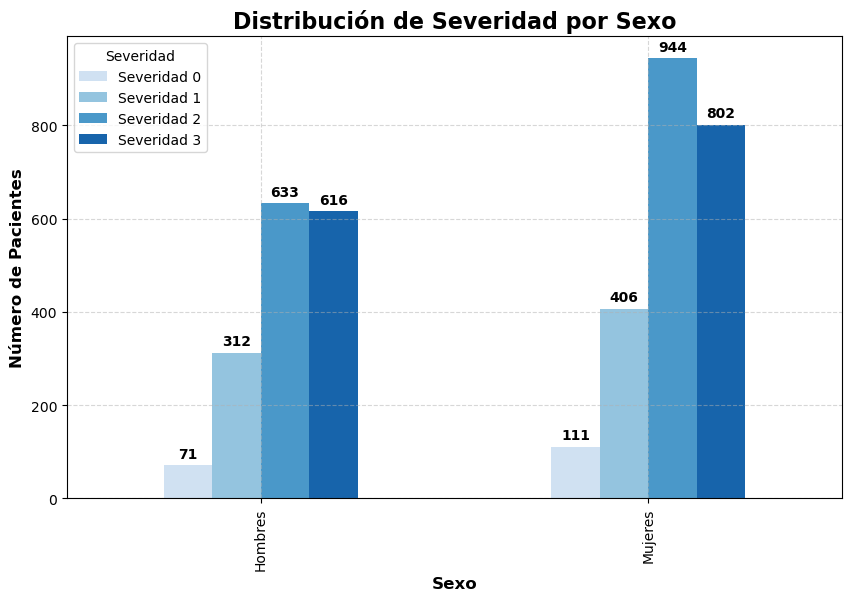

In [25]:
import seaborn as sns

# Contar pacientes por severidad y sexo
severidad_sexo = df.groupby(['SEXO', 'IR_29301_SEVERIDAD']).size().unstack()

# Crear un gráfico de barras con colores azul para severidad
plt.figure(figsize=(10, 6))
severidad_sexo.plot(kind='bar', stacked=False, figsize=(10, 6),
                    color=sns.color_palette("Blues", 4))  # Usar la paleta de colores 'Blues' con 4 colores para severidad

# Personalizar el gráfico
plt.title('Distribución de Severidad por Sexo', fontsize=16, fontweight='bold')
plt.xlabel('Sexo', fontsize=12, fontweight='bold')
plt.ylabel('Número de Pacientes', fontsize=12, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Hombres', 'Mujeres'])

# Añadir los números en las barras
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height + 10, f'{height:.0f}',
             ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Añadir la leyenda para las severidades
plt.legend(title='Severidad', labels=['Severidad 0', 'Severidad 1', 'Severidad 2', 'Severidad 3'], loc='upper left')

# Mostrar el gráfico
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


C:\Users\musra\AppData\Local\Temp\ipykernel_16172\3576195101.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SEXO', y='IR_29301_SEVERIDAD', data=df, palette='Blues')


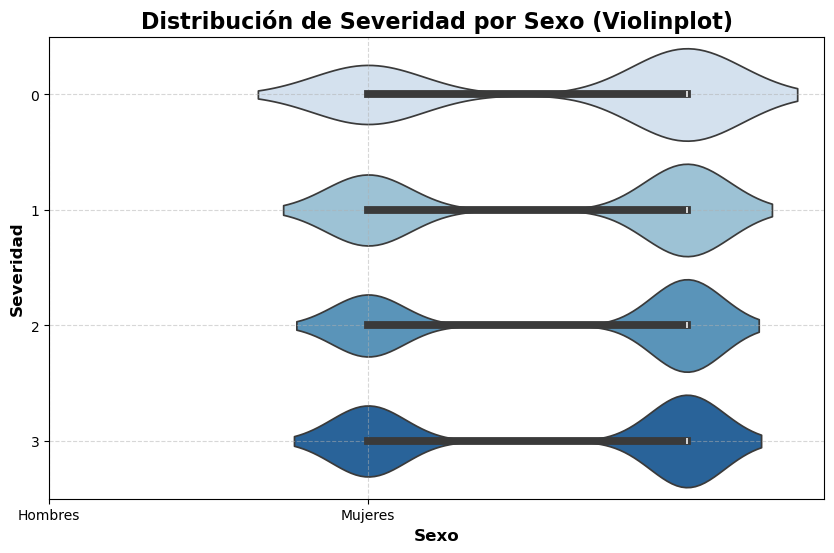

In [26]:
# Crear un violinplot para visualizar la distribución de severidad por sexo
plt.figure(figsize=(10, 6))
sns.violinplot(x='SEXO', y='IR_29301_SEVERIDAD', data=df, palette='Blues')
plt.title('Distribución de Severidad por Sexo (Violinplot)', fontsize=16, fontweight='bold')
plt.xlabel('Sexo', fontsize=12, fontweight='bold')
plt.ylabel('Severidad', fontsize=12, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Hombres', 'Mujeres'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


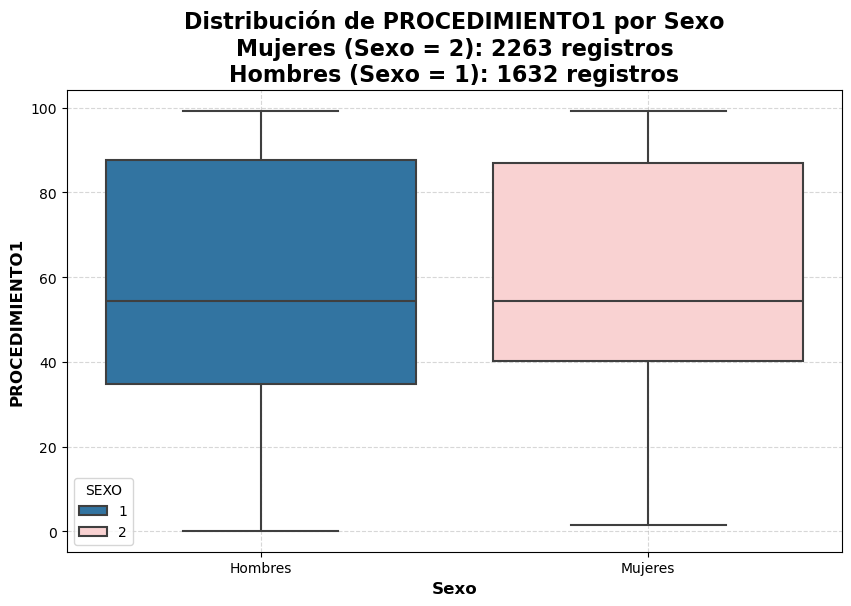

In [27]:
# Crear el boxplot para PROCEDIMIENTO1 por sexo
plt.figure(figsize=(10, 6))
sns.boxplot(x='SEXO', y='PROCEDIMIENTO1', data=df,
            hue='SEXO', palette={1: "#1f77b4", 2: "#ffcccc"}, linewidth=1.5)  # Azul para hombres, rojo pálido para mujeres

# Título con el número total de registros
total_pacientes = df.groupby('SEXO').size()
plt.title(f'Distribución de PROCEDIMIENTO1 por Sexo\nMujeres (Sexo = 2): {total_pacientes[2]} registros\n'
          f'Hombres (Sexo = 1): {total_pacientes[1]} registros', fontsize=16, fontweight='bold')

# Etiquetas de los ejes
plt.xlabel('Sexo', fontsize=12, fontweight='bold')
plt.ylabel('PROCEDIMIENTO1', fontsize=12, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Hombres', 'Mujeres'])

# Mostrar el gráfico
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


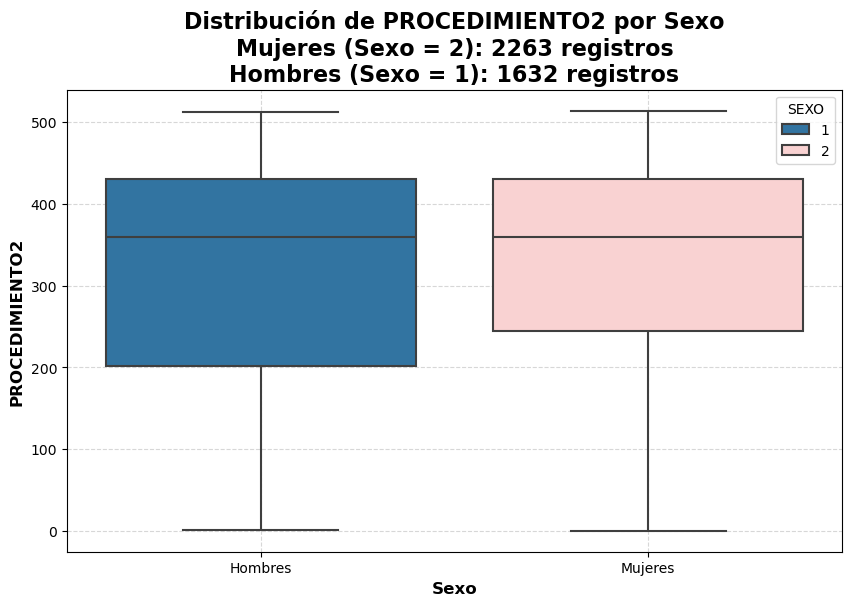

In [29]:
# Crear el boxplot para PROCEDIMIENTO2 por sexo
plt.figure(figsize=(10, 6))
sns.boxplot(x='SEXO', y='PROCEDIMIENTO2', data=df,
            hue='SEXO', palette={1: "#1f77b4", 2: "#ffcccc"}, linewidth=1.5, dodge=False)  # Azul para hombres, rojo pálido para mujeres

# Título con el número total de registros
total_pacientes = df.groupby('SEXO').size()
plt.title(f'Distribución de PROCEDIMIENTO2 por Sexo\nMujeres (Sexo = 2): {total_pacientes[2]} registros\n'
          f'Hombres (Sexo = 1): {total_pacientes[1]} registros', fontsize=16, fontweight='bold')

# Etiquetas de los ejes
plt.xlabel('Sexo', fontsize=12, fontweight='bold')
plt.ylabel('PROCEDIMIENTO2', fontsize=12, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Hombres', 'Mujeres'])

# Mostrar el gráfico
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


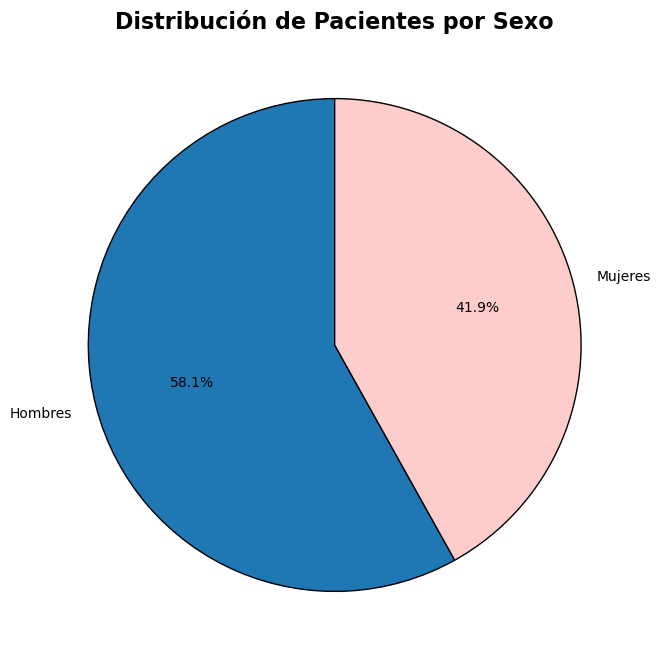

In [30]:
# Calcular el número total de pacientes por sexo
sexo_counts = df['SEXO'].value_counts()

# Crear el gráfico de torta (pie chart) para mostrar la distribución por sexo
plt.figure(figsize=(8, 8))
plt.pie(sexo_counts, labels=['Hombres', 'Mujeres'], autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ffcccc'], wedgeprops={'edgecolor': 'black'})

# Título
plt.title('Distribución de Pacientes por Sexo', fontsize=16, fontweight='bold')

# Mostrar el gráfico
plt.show()
